In [1]:
import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

import gc
from IPython.display import clear_output
from typing import Optional, Tuple, List, Union, Any
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tnrange

from itertools import chain
from skimage.morphology import label
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, concatenate_images

import tensorflow as tf
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import concatenate, add
from keras.layers import Lambda, RepeatVector, Reshape, Conv2D, Conv2DTranspose, MaxPooling2D, GlobalMaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout


import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, BatchNormalization, Activation, Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from skimage.transform import resize
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [2]:
import os
import numpy as np
import pandas as pd
import cv2
from skimage.transform import resize
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, Activation, BatchNormalization, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, Activation, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
import os
import cv2
from skimage.transform import resize

In [3]:
import os
import numpy as np
import pandas as pd
import cv2
from skimage.transform import resize
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, Activation, BatchNormalization, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from google.colab import drive
import tensorflow as tf

In [4]:
from keras.layers import UpSampling2D
import tensorflow.keras.backend as K


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
import numpy as np
from skimage.transform import resize
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Cargar los DataFrames desde los archivos CSV
csv_path_1 = '/content/drive/MyDrive/data/Etiquetas/meta_created_info_3d_3R.csv'
csv_path_2 = '/content/drive/MyDrive/data/Etiquetas/meta_created_info_3d_4R.csv'

data_df_1 = pd.read_csv(csv_path_1)
data_df_2 = pd.read_csv(csv_path_2)

# Concatenar los DataFrames
combined_df = pd.concat([data_df_1, data_df_2], ignore_index=True)

# Filtrar para incluir solo 'True' y 'False'
filtered_df = combined_df[combined_df['is_cancer'].isin(['True', 'False'])]

# Mapear 'True' a 1 y 'False' a 0
filtered_df['is_cancer'] = filtered_df['is_cancer'].map({'True': 1, 'False': 0})

# Extraer descriptores de forma del CSV y normalizarlos
shape_descriptors_csv = filtered_df[['lobulation', 'texture', 'spiculation', 'margin']].values
scaler_csv = StandardScaler()
normalized_shape_descriptors_csv = scaler_csv.fit_transform(shape_descriptors_csv)

# Crear un diccionario para mapear carpetas a etiquetas
image_labels = dict(zip(filtered_df['folder'], filtered_df['is_cancer']))

# Definir las rutas de las carpetas
patch_folder_path = '/content/drive/MyDrive/data/Parches'
mask_folder_path = '/content/drive/MyDrive/data/masks'

# Función para cargar el archivo .npy del medio en la carpeta especificada
def load_middle_npy_file(folder_path):
    files = [f for f in os.listdir(folder_path) if f.endswith('.npy')]
    files.sort()
    middle_index = len(files) // 2
    return np.load(os.path.join(folder_path, files[middle_index])) if files else None

# Listas para almacenar muestras y su información correspondiente
patch_samples = []
mask_samples = []
labels = []
csv_descriptors = []

# Procesar las carpetas comunes entre parches y máscaras
patch_folders = set(os.listdir(patch_folder_path))
mask_folders = set(os.listdir(mask_folder_path))
common_folders = patch_folders & mask_folders
common_folders = [folder for folder in common_folders if folder in image_labels]

for folder_name in common_folders:
    patch = load_middle_npy_file(os.path.join(patch_folder_path, folder_name))
    mask = load_middle_npy_file(os.path.join(mask_folder_path, folder_name))

    if patch is not None and mask is not None:
        # Redimensionar a 32x32
        resized_patch = resize(patch, (32, 32), anti_aliasing=True)
        resized_mask = resize(mask, (32, 32), anti_aliasing=False)

        patch_samples.append(resized_patch)
        mask_samples.append(resized_mask)
        labels.append(image_labels[folder_name])
        csv_descriptors.append(normalized_shape_descriptors_csv[filtered_df['folder'].tolist().index(folder_name)])

# Convertir las listas en arrays de numpy
patch_samples = np.stack(patch_samples)
mask_samples = np.stack(mask_samples)
labels = np.array(labels)
csv_descriptors = np.array(csv_descriptors)

# Normalizar los descriptores combinados
scaler_combined = StandardScaler()
csv_descriptors = scaler_combined.fit_transform(csv_descriptors)

# Verificar la forma de los datos
print(f"Tamaño de los samples de parches: {patch_samples.shape}")
print(f"Tamaño de los samples de máscaras: {mask_samples.shape}")
print(f"Tamaño de los labels: {labels.shape}")
print(f"Tamaño de los descriptores CSV: {csv_descriptors.shape}")


<ipython-input-6-7211c5185b0b>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['is_cancer'] = filtered_df['is_cancer'].map({'True': 1, 'False': 0})


Tamaño de los samples de parches: (533, 32, 32)
Tamaño de los samples de máscaras: (533, 32, 32)
Tamaño de los labels: (533,)
Tamaño de los descriptores CSV: (533, 4)


<ipython-input-8-a144469065db>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['is_cancer'] = filtered_df['is_cancer'].map({'True': 1, 'False': 0})


Accuracy: 0.9437
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        52
           1       0.92      1.00      0.96       108

    accuracy                           0.94       160
   macro avg       0.96      0.91      0.93       160
weighted avg       0.95      0.94      0.94       160



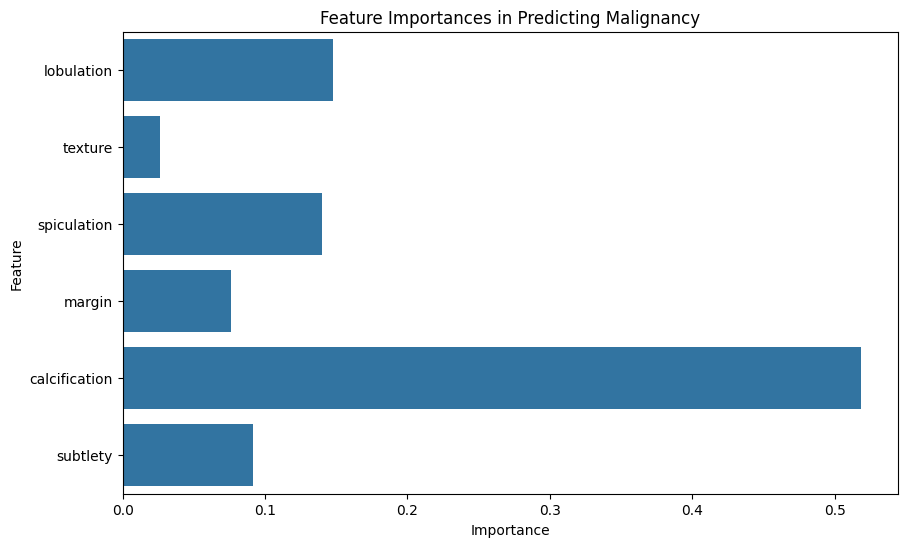

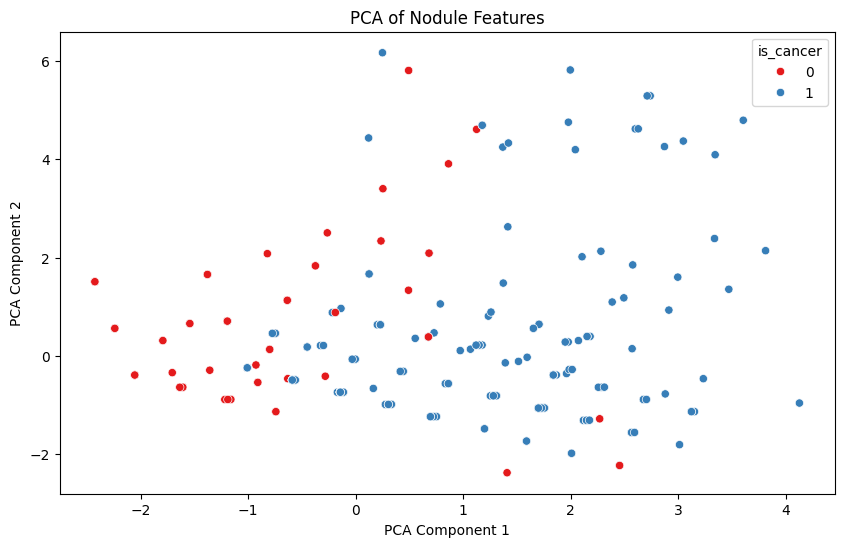

Explained variance by PCA components: [0.39998518 0.27850729]


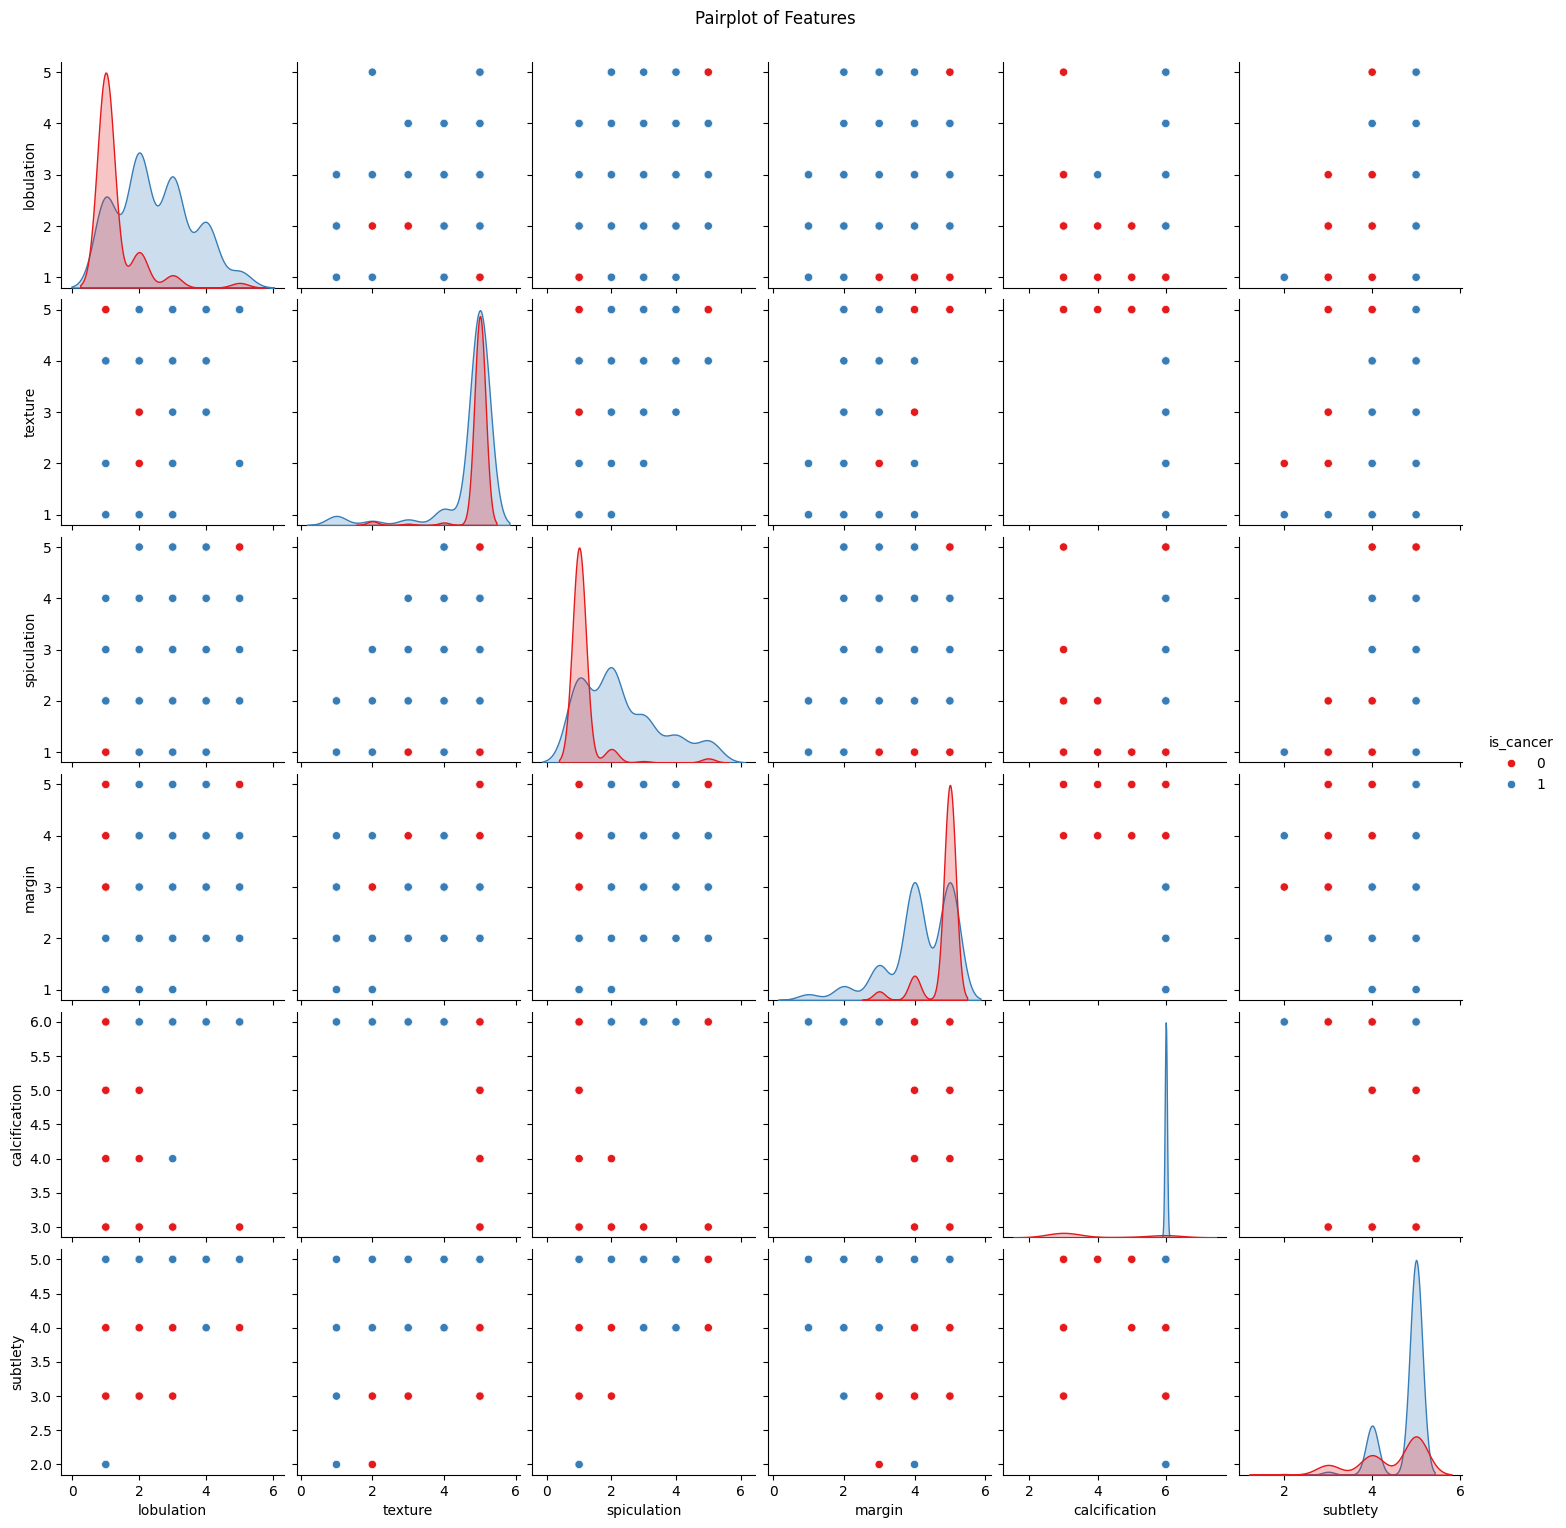

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los DataFrames desde los archivos CSV
csv_path_1 = '/content/drive/MyDrive/data/Etiquetas/meta_created_info_3d_3R.csv'
csv_path_2 = '/content/drive/MyDrive/data/Etiquetas/meta_created_info_3d_4R.csv'

data_df_1 = pd.read_csv(csv_path_1)
data_df_2 = pd.read_csv(csv_path_2)

# Concatenar los DataFrames
combined_df = pd.concat([data_df_1, data_df_2], ignore_index=True)

# Filtrar para incluir solo 'True' y 'False'
filtered_df = combined_df[combined_df['is_cancer'].isin(['True', 'False'])]

# Mapear 'True' a 1 y 'False' a 0
filtered_df['is_cancer'] = filtered_df['is_cancer'].map({'True': 1, 'False': 0})

# Features to use for prediction (all except 'folder' and target 'is_cancer')
features = filtered_df[['lobulation', 'texture', 'spiculation', 'margin', 'calcification', 'subtlety']]

# Target variable
target = filtered_df['is_cancer']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42, stratify=target)

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Get feature importance from the Random Forest model
feature_importances = rf_classifier.feature_importances_
features_list = features.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=features_list)
plt.title('Feature Importances in Predicting Malignancy')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Standardize the data before applying PCA
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['is_cancer'] = target.values

# Plot PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='is_cancer', data=pca_df, palette='Set1')
plt.title('PCA of Nodule Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Variance explained by each principal component
print(f"Explained variance by PCA components: {pca.explained_variance_ratio_}")

# Pairplot of the original features colored by 'is_cancer'
sns.pairplot(filtered_df, hue='is_cancer', vars=features.columns, palette='Set1')
plt.suptitle('Pairplot of Features', y=1.02)
plt.show()


In [ ]:
# Contar cuántos datos son malignos y cuántos son benignos en todo el conjunto de datos
class_counts = filtered_df['is_cancer'].value_counts()
print("Distribución de datos en todo el conjunto de datos:")
print(f"Benignos (0): {class_counts[0]}")
print(f"Malignos (1): {class_counts[1]}")

# También puedes revisar el support directamente desde el reporte de clasificación para el conjunto de prueba
print("Support en el conjunto de prueba:")
print(f"Benignos (0): {y_test.value_counts()[0]}")
print(f"Malignos (1): {y_test.value_counts()[1]}")


Distribución de datos en todo el conjunto de datos:
Benignos (0): 174
Malignos (1): 359
Support en el conjunto de prueba:
Benignos (0): 52
Malignos (1): 108


In [8]:
import os
import numpy as np
from skimage.transform import rotate, resize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, Input, Activation, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# Directorios base
base_dir = '/content/drive/MyDrive/data'
subdirs = {
    'train_mask': os.path.join(base_dir, 'train_data', 'masks'),
    'test_mask': os.path.join(base_dir, 'test_data', 'masks'),
    'val_mask': os.path.join(base_dir, 'val_data', 'masks'),
    'train_patch': os.path.join(base_dir, 'train_data', 'patches'),
    'test_patch': os.path.join(base_dir, 'test_data', 'patches'),
    'val_patch': os.path.join(base_dir, 'val_data', 'patches')
}

# Asegurarse que los directorios existan
for subdir in subdirs.values():
    os.makedirs(subdir, exist_ok=True)

# Aumento de datos por rotaciones
rotation_angles = [90, 180, 270]  # Ángulos de rotación en grados

def augment_data(patches, masks, csv_descriptors, labels, angles=rotation_angles):
    augmented_patches = []
    augmented_masks = []
    augmented_csv_descriptors = []
    augmented_labels = []

    # Aplicar rotaciones a cada parche y máscara
    for i in range(len(patches)):
        patch = patches[i]
        mask = masks[i]
        label = labels[i]
        csv_descriptor = csv_descriptors[i]  # El descriptor CSV no cambia con las rotaciones

        # Añadir la imagen original
        augmented_patches.append(patch)
        augmented_masks.append(mask)
        augmented_labels.append(label)
        augmented_csv_descriptors.append(csv_descriptor)

        # Aplicar rotaciones
        for angle in angles:
            rotated_patch = rotate(patch, angle, resize=False)
            rotated_mask = rotate(mask, angle, resize=False)

            augmented_patches.append(rotated_patch)
            augmented_masks.append(rotated_mask)
            augmented_labels.append(label)
            augmented_csv_descriptors.append(csv_descriptor)  # El CSV sigue siendo el mismo

    return np.array(augmented_patches), np.array(augmented_masks), np.array(augmented_csv_descriptors), np.array(augmented_labels)

# Procesar las carpetas comunes entre parches y máscaras
patch_folders = set(os.listdir(patch_folder_path))
mask_folders = set(os.listdir(mask_folder_path))
common_folders = patch_folders & mask_folders
common_folders = [folder for folder in common_folders if folder in image_labels]

# Listas para almacenar muestras y su información correspondiente
patch_samples = []
mask_samples = []
labels = []
csv_descriptors = []

for folder_name in common_folders:
    patch = load_middle_npy_file(os.path.join(patch_folder_path, folder_name))
    mask = load_middle_npy_file(os.path.join(mask_folder_path, folder_name))

    if patch is not None and mask is not None:
        # Redimensionar a 32x32
        resized_patch = resize(patch, (32, 32), anti_aliasing=True)
        resized_mask = resize(mask, (32, 32), anti_aliasing=False)

        patch_samples.append(resized_patch)
        mask_samples.append(resized_mask)
        labels.append(image_labels[folder_name])
        csv_descriptors.append(normalized_shape_descriptors_csv[filtered_df['folder'].tolist().index(folder_name)])

# Convertir las listas en arrays de numpy
patch_samples = np.stack(patch_samples)
mask_samples = np.stack(mask_samples)
labels = np.array(labels)
csv_descriptors = np.array(csv_descriptors)

# Aumentar los datos aplicando rotaciones a los parches, máscaras y etiquetas (los CSV permanecen igual)
augmented_patches, augmented_masks, augmented_csv_descriptors, augmented_labels = augment_data(
    patch_samples, mask_samples, csv_descriptors, labels)


print(f"Tamaño de los samples de parches después del aumento: {augmented_patches.shape}")
print(f"Tamaño de los samples de máscaras después del aumento: {augmented_masks.shape}")
print(f"Tamaño de los labels después del aumento: {augmented_labels.shape}")
print(f"Tamaño de los descriptores CSV después del aumento: {augmented_csv_descriptors.shape}")

# Partición de los datos aumentados en conjuntos de entrenamiento, validación y prueba
train_patches, test_patches, train_masks, test_masks, train_labels, test_labels, train_csv_descriptors, test_csv_descriptors = train_test_split(
    augmented_patches, augmented_masks, augmented_labels, augmented_csv_descriptors, test_size=0.2, random_state=42)

train_patches, val_patches, train_masks, val_masks, train_labels, val_labels, train_csv_descriptors, val_csv_descriptors = train_test_split(
    train_patches, train_masks, train_labels, train_csv_descriptors, test_size=0.2, random_state=42)

# Función para guardar datos en archivos npy
def save_data(data, dir_path, prefix):
    for i, sample in enumerate(data):
        np.save(os.path.join(dir_path, f'{prefix}_{i}.npy'), sample)

# Guardar los datos de entrenamiento
save_data(train_masks, subdirs['train_mask'], 'mask')
save_data(train_patches, subdirs['train_patch'], 'patch')

# Guardar los datos de prueba
save_data(test_masks, subdirs['test_mask'], 'mask')
save_data(test_patches, subdirs['test_patch'], 'patch')

# Guardar los datos de validación
save_data(val_masks, subdirs['val_mask'], 'mask')
save_data(val_patches, subdirs['val_patch'], 'patch')

print(f"Train samples: {len(train_patches)}, Validation samples: {len(val_patches)}, Test samples: {len(test_patches)}")


Tamaño de los samples de parches después del aumento: (2132, 32, 32)
Tamaño de los samples de máscaras después del aumento: (2132, 32, 32)
Tamaño de los labels después del aumento: (2132,)
Tamaño de los descriptores CSV después del aumento: (2132, 4)
Train samples: 1364, Validation samples: 341, Test samples: 427


In [9]:
# Verificar las formas de los datos y descriptores
print(f"Tamaño de los descriptores de entrenamiento: {train_csv_descriptors.shape}")
print(f"Tamaño de los descriptores de validación: {val_csv_descriptors.shape}")
print(f"Tamaño de los descriptores de prueba: {test_csv_descriptors.shape}")


Tamaño de los descriptores de entrenamiento: (1364, 4)
Tamaño de los descriptores de validación: (341, 4)
Tamaño de los descriptores de prueba: (427, 4)


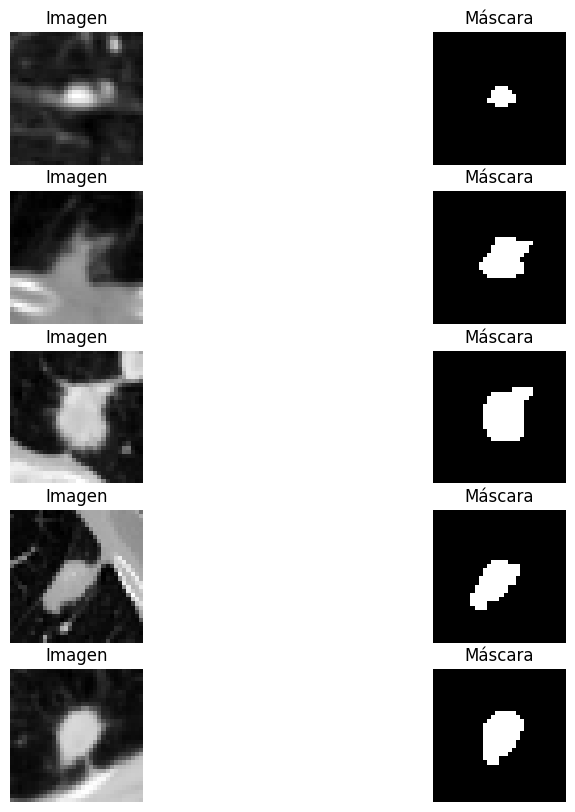

In [10]:
def visualize_samples(patches, masks, num_samples=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(num_samples, 2, 2*i+1)
        plt.imshow(patches[i].squeeze(), cmap='gray')
        plt.title('Imagen')
        plt.axis('off')

        plt.subplot(num_samples, 2, 2*i+2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Máscara')
        plt.axis('off')
    plt.show()

visualize_samples(train_patches, train_masks)


In [11]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               kernel_initializer='he_normal', padding='same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [12]:
# Definir la U-Net con dos entradas (imágenes y CSV) y con salidas para segmentación y clasificación
def get_unet_with_csv_input(input_img, input_csv, n_filters=16, dropout=0.1, batchnorm=True):
    # Bloque U-Net (entrada de imagen)
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters=n_filters * 16, kernel_size=3, batchnorm=batchnorm)

    # Aplanar la salida de c5 para combinarla con la entrada CSV
    c5_flat = Flatten()(c5)

    # Procesar la entrada CSV
    csv_embedding = Dense(128, activation='relu')(input_csv)
    csv_embedding = Dropout(dropout)(csv_embedding)
    csv_embedding = Dense(64, activation='relu')(csv_embedding)

    # Concatenar el embebido de la imagen (c5) con el embebido del CSV
    combined_embedding = concatenate([c5_flat, csv_embedding])

    # Pasar la concatenación por una capa densa (o más capas) para procesamiento adicional
    combined_output = Dense(64, activation='relu')(combined_embedding)
    combined_output = Dropout(dropout)(combined_output)

    # Salida de la clasificación
    classification_output = Dense(1, activation='sigmoid', name='classification_output')(combined_output)

    # Decodificación de la U-Net después de la concatenación
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size=3, batchnorm=batchnorm)

    # Salida de la segmentación
    segmentation_output = Conv2D(1, (1, 1), activation='sigmoid', name='segmentation_output')(c9)

    return Model(inputs=[input_img, input_csv], outputs=[segmentation_output, classification_output])


In [13]:
# Definir las entradas
input_img = Input((32, 32, 1), name='img')
input_csv = Input((train_csv_descriptors.shape[1],), name='csv_data')

# Crear el modelo U-Net con las dos entradas
model_unet_with_csv = get_unet_with_csv_input(input_img, input_csv, n_filters=16, dropout=0.1, batchnorm=True)

# Compilar el modelo
model_unet_with_csv.compile(optimizer='adam',
                            loss={'segmentation_output': 'binary_crossentropy',
                                  'classification_output': 'binary_crossentropy'},
                            metrics={'segmentation_output': 'accuracy',
                                     'classification_output': 'accuracy'})

# Entrenamiento del modelo
history = model_unet_with_csv.fit(
    [train_patches, train_csv_descriptors],  # Imágenes y CSV ya integrados
    [train_masks, train_labels],  # Máscaras y etiquetas de clasificación
    epochs=50,
    batch_size=32,
    validation_data=([val_patches, val_csv_descriptors], [val_masks, val_labels]),
    callbacks=[
        ModelCheckpoint('best_model_with_csv.h5.keras', save_best_only=True, monitor='val_loss', mode='min'),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]
)


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 49s 691ms/step - classification_output_accuracy: 0.7491 - loss: 1.0121 - segmentation_output_accuracy: 0.8635 - val_classification_output_accuracy: 0.3431 - val_loss: 1.9523 - val_segmentation_output_accuracy: 0.6330
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 39s 647ms/step - classification_output_accuracy: 0.9189 - loss: 0.3634 - segmentation_output_accuracy: 0.9796 - val_classification_output_accuracy: 0.8094 - val_loss: 0.7054 - val_segmentation_output_accuracy: 0.9578
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 41s 647ms/step - classification_output_accuracy: 0.9279 - loss: 0.2770 - segmentation_output_accuracy: 0.9826 - val_classification_output_accuracy: 0.7449 - val_loss: 0.6740 - val_segmentation_output_accuracy: 0.9607
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 41s 656ms/step - classification_output_accuracy: 0.9575 - loss: 0.2257 - segmentation_output_accuracy: 0.9834 - val_classification_output_accuracy: 0.8035 - val_loss: 0.6718 - val_segmentation_outp

In [14]:
# Visualización de predicciones de segmentación con umbral
import matplotlib.pyplot as plt

def plot_sample_images(patches, masks, predictions, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(3, num_samples, i+1)
        plt.imshow(patches[i].squeeze(), cmap='gray')
        plt.title('Imagen')
        plt.axis('off')

        plt.subplot(3, num_samples, i+1+num_samples)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Máscara')
        plt.axis('off')


        plt.subplot(3, num_samples, i+1+2*num_samples)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title('Predicción')
        plt.axis('off')

    plt.show()




11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step


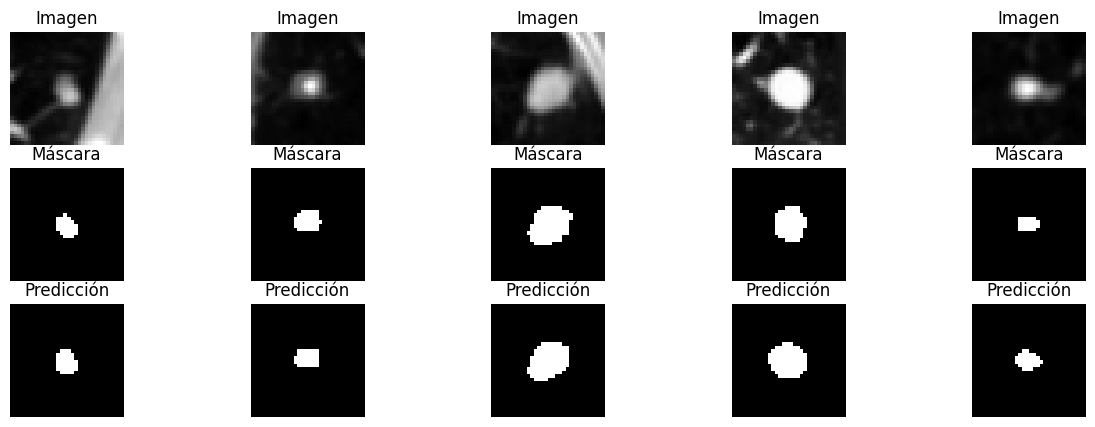

In [15]:
# Obtener las predicciones de segmentación con los datos de validación
predictions, _ = model_unet_with_csv.predict([val_patches, val_csv_descriptors])

# Aplicar el umbral para obtener máscaras binarias
predictions = (predictions > 0.5).astype('float32')

# Visualizar algunas predicciones
plot_sample_images(val_patches, val_masks, predictions)

In [16]:
# Obtener el embebido combinado de la U-Net para los datos de entrenamiento y validación aumentados
train_embeddings, _ = model_unet_with_csv.predict([augmented_patches, augmented_csv_descriptors])
val_embeddings, _ = model_unet_with_csv.predict([val_patches, val_csv_descriptors])

# Aplanar las salidas de los embebidos si es necesario
train_embeddings_flat = train_embeddings.reshape((train_embeddings.shape[0], -1))
val_embeddings_flat = val_embeddings.reshape((val_embeddings.shape[0], -1))

# Clasificación con Random Forest usando SOLO el embebido combinado de las imágenes aumentadas
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, classification_report
from sklearn.model_selection import KFold

67/67 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


In [20]:
# Obtener los embebidos de la U-Net para los datos de entrenamiento y validación
train_embeddings, _ = model_unet_with_csv.predict([train_patches, train_csv_descriptors])
val_embeddings, _ = model_unet_with_csv.predict([val_patches, val_csv_descriptors])

# Aplanar las salidas de los embebidos si es necesario
train_embeddings_flat = train_embeddings.reshape((train_embeddings.shape[0], -1))
val_embeddings_flat = val_embeddings.reshape((val_embeddings.shape[0], -1))

# Verificar tamaños
print(f"Tamaño de los embeddings de entrenamiento: {train_embeddings_flat.shape}")
print(f"Tamaño de las etiquetas de entrenamiento: {train_labels.shape}")

# Verifica que las formas coincidan antes de continuar
assert train_embeddings_flat.shape[0] == train_labels.shape[0], "El número de embeddings no coincide con las etiquetas de entrenamiento."

43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step
Tamaño de los embeddings de entrenamiento: (1364, 1024)
Tamaño de las etiquetas de entrenamiento: (1364,)


In [21]:
# Clasificación con Random Forest usando SOLO el embebido combinado
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, classification_report
from sklearn.model_selection import KFold

# Random Forest
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)

# Usar KFold para la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Listas para almacenar métricas generales y por clase
accuracies = []
aucs = []
recalls = []
precisions = []
f1_scores = []

precision_0 = []
precision_1 = []
recall_0 = []
recall_1 = []
f1_0 = []
f1_1 = []

# Validación cruzada con KFold
for train_index, test_index in kf.split(train_embeddings_flat):
    X_train, X_test = train_embeddings_flat[train_index], train_embeddings_flat[test_index]
    y_train, y_test = train_labels[train_index], train_labels[test_index]

    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

    accuracies.append(accuracy_score(y_test, y_pred))
    aucs.append(roc_auc_score(y_test, y_pred_proba))
    recalls.append(recall_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

    # Reporte de clasificación para cada fold
    report = classification_report(y_test, y_pred, output_dict=True)

    # Guardar las métricas de la clase 0 (no cáncer)
    precision_0.append(report['0']['precision'])
    recall_0.append(report['0']['recall'])
    f1_0.append(report['0']['f1-score'])

    # Guardar las métricas de la clase 1 (cáncer)
    precision_1.append(report['1']['precision'])
    recall_1.append(report['1']['recall'])
    f1_1.append(report['1']['f1-score'])

# Calcular la media y la desviación estándar de las métricas generales
accuracy_mean = np.mean(accuracies)
accuracy_std = np.std(accuracies)
auc_mean = np.mean(aucs)
auc_std = np.std(aucs)
recall_mean = np.mean(recalls)
recall_std = np.std(recalls)
precision_mean = np.mean(precisions)
precision_std = np.std(precisions)
f1_mean = np.mean(f1_scores)
f1_std = np.std(f1_scores)

# Calcular la media y la desviación estándar de las métricas por clase
precision_0_mean = np.mean(precision_0)
precision_0_std = np.std(precision_0)
recall_0_mean = np.mean(recall_0)
recall_0_std = np.std(recall_0)
f1_0_mean = np.mean(f1_0)
f1_0_std = np.std(f1_0)

precision_1_mean = np.mean(precision_1)
precision_1_std = np.std(precision_1)
recall_1_mean = np.mean(recall_1)
recall_1_std = np.std(recall_1)
f1_1_mean = np.mean(f1_1)
f1_1_std = np.std(f1_1)

# Mostrar los resultados generales
print(f"Random Forest Accuracy: {accuracy_mean:.4f} ± {accuracy_std:.4f}")
print(f"Random Forest AUC: {auc_mean:.4f} ± {auc_std:.4f}")
print(f"Random Forest Recall: {recall_mean:.4f} ± {recall_std:.4f}")
print(f"Random Forest Precision: {precision_mean:.4f} ± {precision_std:.4f}")
print(f"Random Forest F1 Score: {f1_mean:.4f} ± {f1_std:.4f}")

# Mostrar los resultados por clase
print("\nClase 0 (no cáncer):")
print(f"Precision: {precision_0_mean:.4f} ± {precision_0_std:.4f}")
print(f"Recall: {recall_0_mean:.4f} ± {recall_0_std:.4f}")
print(f"F1 Score: {f1_0_mean:.4f} ± {f1_0_std:.4f}")

print("\nClase 1 (cáncer):")
print(f"Precision: {precision_1_mean:.4f} ± {precision_1_std:.4f}")
print(f"Recall: {recall_1_mean:.4f} ± {recall_1_std:.4f}")
print(f"F1 Score: {f1_1_mean:.4f} ± {f1_1_std:.4f}")

Random Forest Accuracy: 0.9289 ± 0.0129
Random Forest AUC: 0.9669 ± 0.0171
Random Forest Recall: 0.9595 ± 0.0082
Random Forest Precision: 0.9383 ± 0.0120
Random Forest F1 Score: 0.9487 ± 0.0080

Clase 0 (no cáncer):
Precision: 0.9057 ± 0.0277
Recall: 0.8617 ± 0.0349
F1 Score: 0.8830 ± 0.0289

Clase 1 (cáncer):
Precision: 0.9383 ± 0.0120
Recall: 0.9595 ± 0.0082
F1 Score: 0.9487 ± 0.0080


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, classification_report
from sklearn.model_selection import KFold

# Clasificación con Random Forest usando el embebido combinado
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)

# Usar KFold para la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Listas para almacenar las métricas generales y por clase
accuracies = []
aucs = []
recalls = []
precisions = []
f1_scores = []

precision_0 = []
precision_1 = []
recall_0 = []
recall_1 = []
f1_0 = []
f1_1 = []

# Realizar la validación cruzada
for train_index, test_index in kf.split(train_combined_embeddings):
    X_train, X_test = train_combined_embeddings[train_index], train_combined_embeddings[test_index]
    y_train, y_test = train_labels[train_index], train_labels[test_index]

    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

    accuracies.append(accuracy_score(y_test, y_pred))
    aucs.append(roc_auc_score(y_test, y_pred_proba))
    recalls.append(recall_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

    # Reporte de clasificación para cada fold
    report = classification_report(y_test, y_pred, output_dict=True)

    # Guardar las métricas de la clase 0 (no cáncer)
    precision_0.append(report['0']['precision'])
    recall_0.append(report['0']['recall'])
    f1_0.append(report['0']['f1-score'])

    # Guardar las métricas de la clase 1 (cáncer)
    precision_1.append(report['1']['precision'])
    recall_1.append(report['1']['recall'])
    f1_1.append(report['1']['f1-score'])

# Calcular la media y la desviación estándar de las métricas generales
accuracy_mean = np.mean(accuracies)
accuracy_std = np.std(accuracies)
auc_mean = np.mean(aucs)
auc_std = np.std(aucs)
recall_mean = np.mean(recalls)
recall_std = np.std(recalls)
precision_mean = np.mean(precisions)
precision_std = np.std(precisions)
f1_mean = np.mean(f1_scores)
f1_std = np.std(f1_scores)

# Calcular la media y la desviación estándar de las métricas por clase
precision_0_mean = np.mean(precision_0)
precision_0_std = np.std(precision_0)
recall_0_mean = np.mean(recall_0)
recall_0_std = np.std(recall_0)
f1_0_mean = np.mean(f1_0)
f1_0_std = np.std(f1_0)

precision_1_mean = np.mean(precision_1)
precision_1_std = np.std(precision_1)
recall_1_mean = np.mean(recall_1)
recall_1_std = np.std(recall_1)
f1_1_mean = np.mean(f1_1)
f1_1_std = np.std(f1_1)

# Mostrar los resultados generales
print(f"Random Forest Accuracy: {accuracy_mean:.4f} ± {accuracy_std:.4f}")
print(f"Random Forest AUC: {auc_mean:.4f} ± {auc_std:.4f}")
print(f"Random Forest Recall: {recall_mean:.4f} ± {recall_std:.4f}")
print(f"Random Forest Precision: {precision_mean:.4f} ± {precision_std:.4f}")
print(f"Random Forest F1 Score: {f1_mean:.4f} ± {f1_std:.4f}")

# Mostrar los resultados por clase
print("\nClase 0 (no cáncer):")
print(f"Precision: {precision_0_mean:.4f} ± {precision_0_std:.4f}")
print(f"Recall: {recall_0_mean:.4f} ± {recall_0_std:.4f}")
print(f"F1 Score: {f1_0_mean:.4f} ± {f1_0_std:.4f}")

print("\nClase 1 (cáncer):")
print(f"Precision: {precision_1_mean:.4f} ± {precision_1_std:.4f}")
print(f"Recall: {recall_1_mean:.4f} ± {recall_1_std:.4f}")
print(f"F1 Score: {f1_1_mean:.4f} ± {f1_1_std:.4f}")
